In [ ]:
# importing all the necessary library used

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#labelling all the directory

labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
labels

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
#adding path, resizing and adding to list

X_train = []
y_train = []
image_size = 240
dir = '/content/drive/MyDrive/b'
for i in labels:
    folderPath = os.path.join(dir,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(dir,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:48<00:00,  1.54it/s]


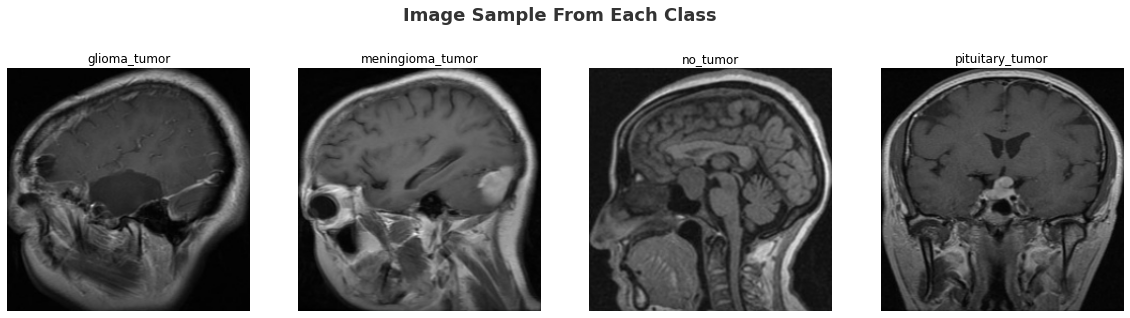

In [ ]:
#displaying mri from each directory

k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Image Sample From Each Class',size=18,fontweight='bold',
             y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
#shuffling mri from each folder so that every time new set is generated

X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
#spliting data in train and test set

X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
#one hot encoding 

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
#checking number of images in each class in the training dataset

No_images_per_class = []
Class_name = []

for i in os.listdir('/content/drive/MyDrive/b/Training'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/b/Training', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in pituitary_tumor = 827 

Number of images in no_tumor = 395 

Number of images in meningioma_tumor = 822 

Number of images in glioma_tumor = 826 



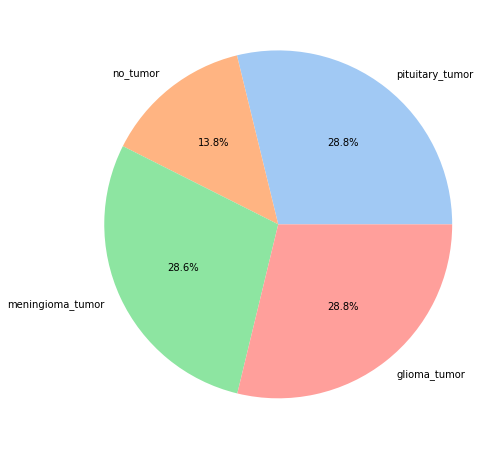

In [ ]:
#visualizing class distribution in train set

plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

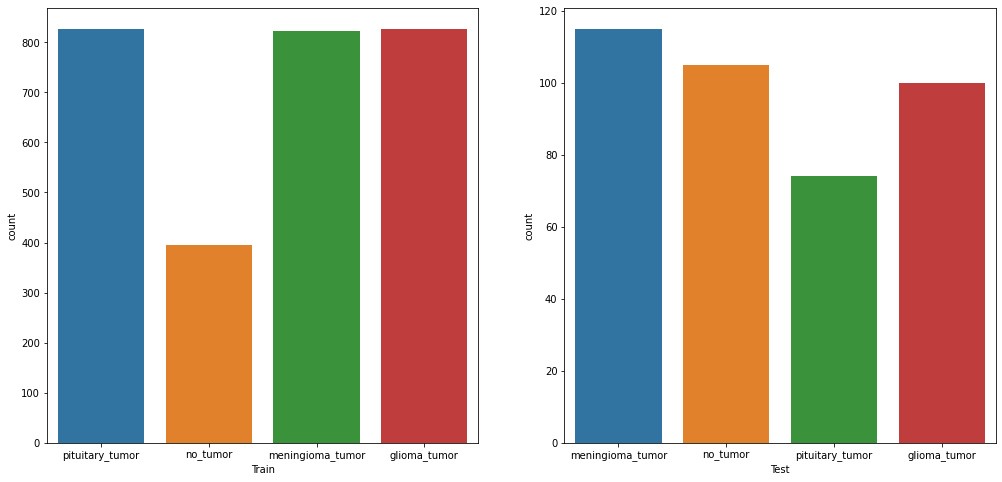

In [ ]:
#visualizing class distribution in train set and test set

train_labels = []
test_labels = []

dir = '/content/drive/MyDrive/b'

img_size= 240

for i in os.listdir(dir+'/Training/'):
    for j in os.listdir(dir+"/Training/"+i):
       train_labels.append(i)
        
for i in os.listdir(dir+'/Testing/'):
    for j in os.listdir(dir+"/Testing/"+i):
        test_labels.append(i)

plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [ ]:
#fine-tuned efficientnetB0

image_size = 240
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(512,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.25)(model)
model = tf.keras.layers.Dense(256,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.25)(model)
model = tf.keras.layers.Dense(128,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 240, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 240, 240, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
#compile the model

model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("EfficientNetbB0.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
#fitting data to a model

history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,earlystop,reduce_lr])

Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8464
Epoch 1: val_accuracy improved from -inf to 0.86735, saving model to EfficientNetbB0.h5
83/83 [==============================] - 52s 392ms/step - loss: 0.4015 - accuracy: 0.8464 - val_loss: 0.5118 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9361
Epoch 2: val_accuracy did not improve from 0.86735
83/83 [==============================] - 29s 345ms/step - loss: 0.1938 - accuracy: 0.9361 - val_loss: 0.6200 - val_accuracy: 0.8061 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9712
Epoch 3: val_accuracy improved from 0.86735 to 0.93878, saving model to EfficientNetbB0.h5
83/83 [==============================] - 30s 361ms/step - loss: 0.0877 - accuracy: 0.9712 - val_loss: 0.2450 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - E

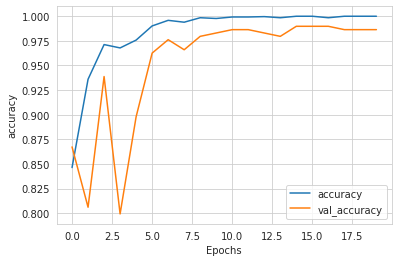

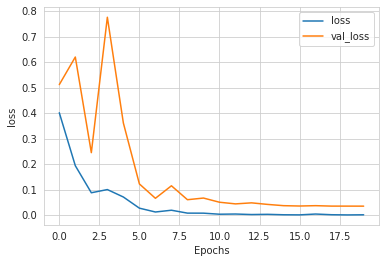

In [ ]:
#Visualizing accuracy and loss of training and validation set

def plot_graphs(history, string):
    sns.set_style("whitegrid")
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')


In [ ]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 1s 103ms/step - loss: 0.0964 - accuracy: 0.9786


[0.09644227474927902, 0.9785932898521423]

In [ ]:
#classification report

pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        93
           1       0.96      0.97      0.96        95
           2       1.00      1.00      1.00        52
           3       1.00      1.00      1.00        87

    accuracy                           0.98       327
   macro avg       0.98      0.98      0.98       327
weighted avg       0.98      0.98      0.98       327



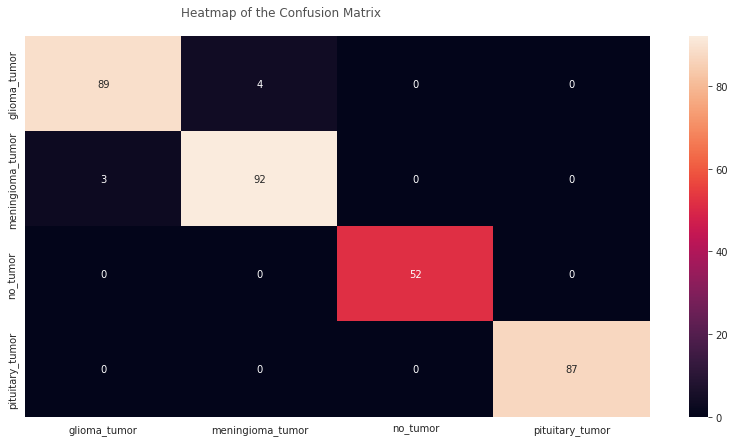

In [ ]:
#confusin matrix

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=12,y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
#prediction MRI from test set

def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(240,240))
    img = img.reshape(1,240,240,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
        print(f'The Model predicts that it is a {p}')
    elif p==1:
        p='Meningioma Tumor'
        print(f'The Model predicts that it is a {p}')
    elif p==3:
        p='Pituitary Tumor'
        print(f'The Model predicts that it is a {p}')
    else:
        p='No Tumor'
        print(f'The Model predicts that it is a {p}')

In [ ]:
#creating widget for uploading and prediction of any MRI

import ipywidgets as widgets

def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')

uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='Predict')
out = widgets.Output()

button.on_click(on_button_clicked)
widgets.VBox([button,out])

FileUpload(value={}, description='Upload')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 238, 238, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                        

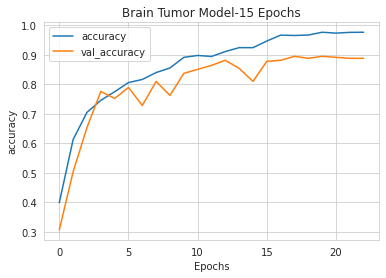

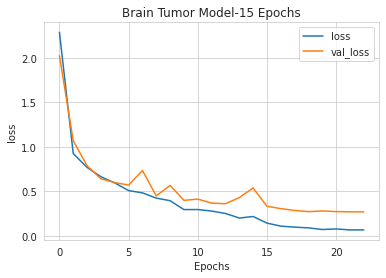

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        93
           1       0.82      0.84      0.83        95
           2       0.87      0.92      0.90        52
           3       0.95      0.94      0.95        87

    accuracy                           0.88       327
   macro avg       0.88      0.88      0.88       327
weighted avg       0.88      0.88      0.88       327



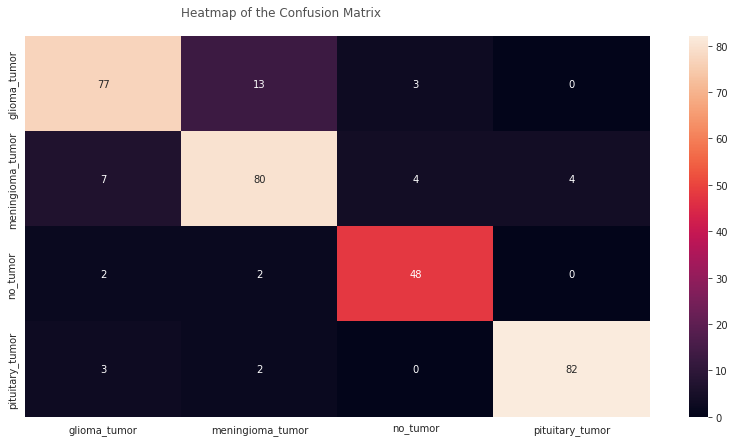

In [ ]:
#Custom CNN 

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.models import load_model

model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("modelcnn.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,earlystop,reduce_lr])



#Visualize Training
def plot_graphs(history, string):
    sns.set_style("whitegrid")
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title("Brain Tumor Model-15 Epochs")
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')



pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))



fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=12,y=0.92,x=0.28,alpha=0.8)

plt.show()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 246, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 120, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

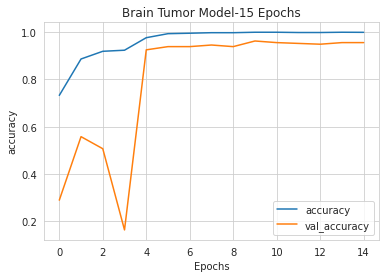

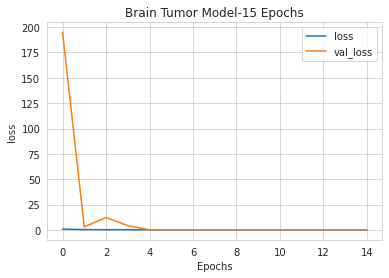

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        93
           1       0.96      0.95      0.95        95
           2       0.98      0.96      0.97        52
           3       0.94      0.98      0.96        87

    accuracy                           0.96       327
   macro avg       0.97      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



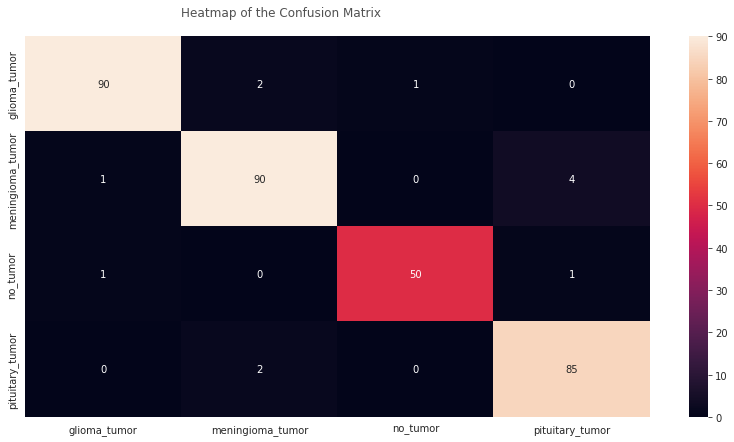

In [ ]:
#ResNet50

from tensorflow.keras.applications.resnet50 import ResNet50
image_size = 240
m = ResNet50(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

model = m.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=m.input, outputs = model)

model.summary()

model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("modelresnet50.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,earlystop,reduce_lr])

#Visualize Training
def plot_graphs(history, string):
    sns.set_style("whitegrid")
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title("Brain Tumor Model-15 Epochs")
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')


#classification report
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))





#confusin matrix
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=12,y=0.92,x=0.28,alpha=0.8)

plt.show()

87924736/87910968 [==============================] - 0s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 119, 119, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 119, 119, 32  96         ['conv2d_3[0][0]']               
 rmalization)              

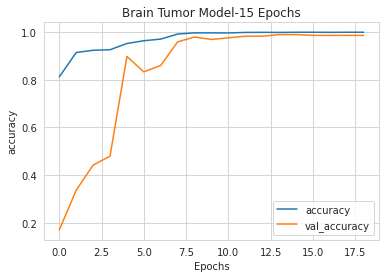

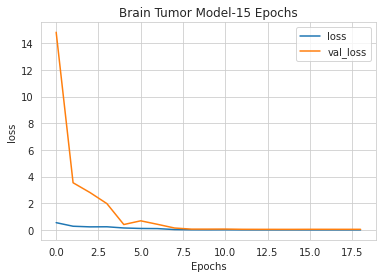

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        93
           1       0.94      0.98      0.96        95
           2       1.00      0.96      0.98        52
           3       0.98      0.98      0.98        87

    accuracy                           0.97       327
   macro avg       0.98      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



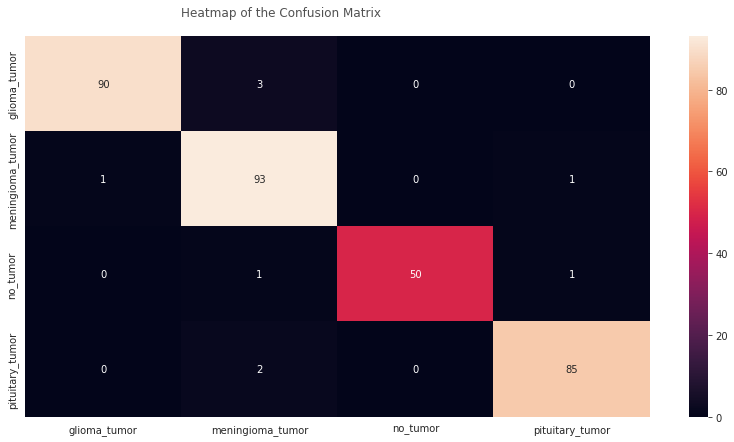

In [ ]:
#InceptionV3

from tensorflow.keras.applications.inception_v3 import InceptionV3

image_size = 240
m = InceptionV3(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

model = m.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=m.input, outputs = model)

model.summary()

model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("modelinceptionv3.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,earlystop,reduce_lr])

#Visualize Training
def plot_graphs(history, string):
    sns.set_style("whitegrid")
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title("Brain Tumor Model-15 Epochs")
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

#classification report
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

#confusin matrix
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=12,y=0.92,x=0.28,alpha=0.8)

plt.show()

17235968/17225924 [==============================] - 1s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 120, 120, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 120, 120, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 120, 120, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 120, 120, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 120, 120, 32)     128  

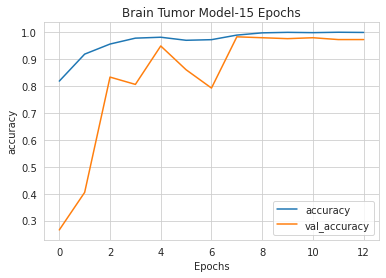

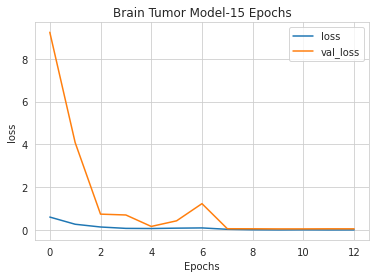

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        93
           1       0.94      0.97      0.95        95
           2       0.98      0.98      0.98        52
           3       1.00      0.97      0.98        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



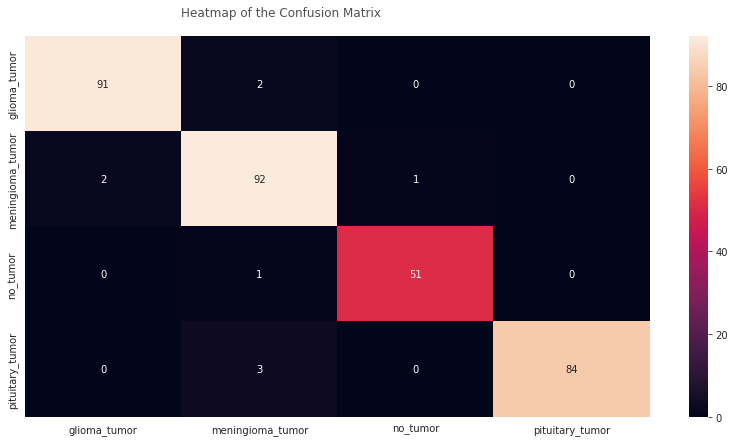

In [ ]:
#MobileNet
from tensorflow.keras.applications import MobileNet
image_size = 240
m = MobileNet(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

model = m.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=m.input, outputs = model)

model.summary()

model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("modelmobilenet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,earlystop,reduce_lr])

#Visualize Training
def plot_graphs(history, string):
    sns.set_style("whitegrid")
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title("Brain Tumor Model-15 Epochs")
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

#classification report
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

#confusin matrix
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=12,y=0.92,x=0.28,alpha=0.8)

plt.show()